In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch

from dask_ml.preprocessing import StandardScaler
from dask_ml.model_selection import train_test_split

In [3]:
DATA_DIR = '../../data/datasets'

In [4]:
# Load the dataset with Dask
ds = xr.open_dataset(f'{DATA_DIR}/era5.nc', chunks={'time': 10})

ds_array = ds.to_array()
# .isel(time=slice(0, 100))
# .transpose('time', 'longitude', 'latitude', 'variable')

print(ds_array.shape)
ds_array

(3, 1468, 64, 32)


<xarray.DataArray (variable: 3, time: 1468, longitude: 64, latitude: 32)>
dask.array<stack, shape=(3, 1468, 64, 32), dtype=float32, chunksize=(1, 10, 64, 32), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01 ... 2021-01-01T18:00:00
  * longitude  (longitude) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * latitude   (latitude) float64 -90.0 -84.19 -78.39 ... 78.39 84.19 90.0
  * variable   (variable) object '10m_wind_speed' ... 'total_precipitation_6hr'

In [5]:
ds_array.dims, ds_array.coords

(('variable', 'time', 'longitude', 'latitude'),
 Coordinates:
   * time       (time) datetime64[ns] 2020-01-01 ... 2021-01-01T18:00:00
   * longitude  (longitude) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
   * latitude   (latitude) float64 -90.0 -84.19 -78.39 ... 78.39 84.19 90.0
   * variable   (variable) object '10m_wind_speed' ... 'total_precipitation_6hr')

# Create Lag Features

In [11]:
obs_window = 5
pred_window = 1

window = obs_window + pred_window
# Apply the rolling function
rolled_dataset = ds_array.rolling(time=window, center=False).construct('window')

print(rolled_dataset.shape)

# rolled_dataset.stack(space=['window', 'variable'])
rolled_dataset = rolled_dataset.assign_coords(window=np.arange(1 - obs_window, pred_window + 1, dtype=np.int8))

print(rolled_dataset.shape)


# Drop the NaNs introduced by rolling
rolled_dataset = rolled_dataset.dropna(dim='time')

print(rolled_dataset.shape)

# Manually slice the data to get non-overlapping windows
rolled_dataset = rolled_dataset.isel(time=slice(0, None, window))

print(rolled_dataset.shape)

# Get the data and targets
X = rolled_dataset.isel(window=slice(obs_window))
# .stack(space=['longitude', 'latitude', 'window', 'variable'])
y = rolled_dataset.isel(window=slice(obs_window, None))
# .stack(space=['longitude', 'latitude', 'window', 'variable'])


(3, 1468, 64, 32, 6)
(3, 1468, 64, 32, 6)
(3, 1463, 64, 32, 6)
(3, 244, 64, 32, 6)


In [12]:
y

<xarray.DataArray (variable: 3, time: 244, longitude: 64, latitude: 32,
                   window: 1)>
dask.array<getitem, shape=(3, 244, 64, 32, 1), dtype=float32, chunksize=(1, 2, 64, 32, 1), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2020-01-02T06:00:00 ... 2020-12-31T18:00:00
  * longitude  (longitude) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * latitude   (latitude) float64 -90.0 -84.19 -78.39 ... 78.39 84.19 90.0
  * variable   (variable) object '10m_wind_speed' ... 'total_precipitation_6hr'
  * window     (window) int8 1

# Train-test split

In [13]:
X = X.unstack().stack(space=['longitude', 'latitude', 'window', 'variable'])
y = y.unstack().stack(space=['longitude', 'latitude', 'window', 'variable'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

X.shape, X_train.shape, X_test.shape
X_train

<xarray.DataArray (time: 195, space: 30720)>
dask.array<getitem, shape=(195, 30720), dtype=float32, chunksize=(1, 10560), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2020-12-09T06:00:00 ... 2020-06-03T06:00:00
  * space      (space) object MultiIndex
  * longitude  (space) float64 0.0 0.0 0.0 0.0 0.0 ... 354.4 354.4 354.4 354.4
  * latitude   (space) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
  * window     (space) int8 -4 -4 -4 -3 -3 -3 -2 -2 -2 ... -2 -2 -1 -1 -1 0 0 0
  * variable   (space) object '10m_wind_speed' ... 'total_precipitation_6hr'

# Scaling

In [15]:
X_scaler = StandardScaler()
y_scaler = StandardScaler()
# Since this is regression, we must also scale the y
X_train_scaled = X_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train)

X_test_scaled = X_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

X_train_scaled

<xarray.DataArray (time: 195, space: 30720)>
dask.array<truediv, shape=(195, 30720), dtype=float32, chunksize=(1, 10560), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2020-12-09T06:00:00 ... 2020-06-03T06:00:00
  * space      (space) object MultiIndex
  * longitude  (space) float64 0.0 0.0 0.0 0.0 0.0 ... 354.4 354.4 354.4 354.4
  * latitude   (space) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
  * window     (space) int8 -4 -4 -4 -3 -3 -3 -2 -2 -2 ... -2 -2 -1 -1 -1 0 0 0
  * variable   (space) object '10m_wind_speed' ... 'total_precipitation_6hr'

In [24]:
# We may or may not want to flatten the observation window
flatten_window = False

# Concate the window and variable dimensions to get a single vector/dimension of lagged features

X_train_scaled_xr = X_train_scaled.unstack()
y_train_scaled_xr = y_train_scaled.unstack()
X_test_scaled_xr = X_test_scaled.unstack()
y_test_scaled_xr = y_test_scaled.unstack()

if flatten_window:
    grouping = ['window', 'variable']

    X_train_scaled_xr = X_train_scaled_xr.stack(lag_features=grouping)
    y_train_scaled_xr = y_train_scaled_xr.stack(lag_features=grouping)
    X_test_scaled_xr = X_test_scaled_xr.stack(lag_features=grouping)
    y_test_scaled_xr = y_test_scaled_xr.stack(lag_features=grouping)

X_train_scaled_xr

<xarray.DataArray (time: 195, longitude: 64, latitude: 32, window: 5,
                   variable: 3)>
dask.array<reshape, shape=(195, 64, 32, 5, 3), dtype=float32, chunksize=(1, 22, 32, 5, 3), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
  * latitude   (latitude) float64 -90.0 -84.19 -78.39 ... 78.39 84.19 90.0
  * window     (window) int8 -4 -3 -2 -1 0
  * variable   (variable) object '10m_wind_speed' ... 'total_precipitation_6hr'
  * time       (time) datetime64[ns] 2020-12-09T06:00:00 ... 2020-06-03T06:00:00

In [25]:
ds.longitude.values

array([  0.   ,   5.625,  11.25 ,  16.875,  22.5  ,  28.125,  33.75 ,
        39.375,  45.   ,  50.625,  56.25 ,  61.875,  67.5  ,  73.125,
        78.75 ,  84.375,  90.   ,  95.625, 101.25 , 106.875, 112.5  ,
       118.125, 123.75 , 129.375, 135.   , 140.625, 146.25 , 151.875,
       157.5  , 163.125, 168.75 , 174.375, 180.   , 185.625, 191.25 ,
       196.875, 202.5  , 208.125, 213.75 , 219.375, 225.   , 230.625,
       236.25 , 241.875, 247.5  , 253.125, 258.75 , 264.375, 270.   ,
       275.625, 281.25 , 286.875, 292.5  , 298.125, 303.75 , 309.375,
       315.   , 320.625, 326.25 , 331.875, 337.5  , 343.125, 348.75 ,
       354.375])

# Make DataSet and DataLoaders


In [26]:
X_train = torch.tensor(X_train_scaled_xr.values, dtype=torch.float32)
y_train = torch.tensor(y_train_scaled_xr.values, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled_xr.values, dtype=torch.float32)
y_test = torch.tensor(y_test_scaled_xr.values, dtype=torch.float32)

In [28]:
X_train.shape

torch.Size([195, 64, 32, 5, 3])

In [29]:
os.makedirs(f'{DATA_DIR}/64x32_10f_5y_3obs_uns', exist_ok=True)

torch.save(X_train, 'datasets/64x32_10f_5y_3obs_uns/X_train.pt')
torch.save(y_train, 'datasets/64x32_10f_5y_3obs_uns/y_train.pt')
torch.save(X_test, 'datasets/64x32_10f_5y_3obs_uns/X_test.pt')
torch.save(y_test, 'datasets/64x32_10f_5y_3obs_uns/y_test.pt')

RuntimeError: Parent directory datasets/64x32_10f_5y_3obs_uns does not exist.

In [11]:
from torch.utils.data import Dataset

class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create dataset instances
train_dataset = WeatherDataset(X_train, y_train)
test_dataset = WeatherDataset(X_test, y_test)

In [20]:
from torch.utils.data import DataLoader

# Parameters
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
train_dataset.X.shape

(234, 24576)

## Optional: Make a graph of the grid data

In [82]:
longitude = ds.longitude.values
latitude = ds.latitude.values

# Initialize a graph
G = nx.Graph()

# Add nodes
for lon in longitude:
    for lat in latitude:
        feature_values = X_test_scaled_xr.isel(time=0).sel(longitude=lon, latitude=lat).values  # Extract features for the first time step
        G.add_node((lon, lat), features=feature_values)

# Add edges (connect each node to its direct neighbors)
for x, lon in enumerate(longitude):
    for y, lat in enumerate(latitude):
        G.add_edge((lon, lat), (longitude[(x + 1) - len(longitude)], lat))  # Connect to the west
        G.add_edge((lon, lat), (lon, latitude[(y + 1)  - len(latitude)]))  # Connect to the north

        # G.add_edge((lon, lat), (longitude[(x + 1) % len(longitude)], lat))  # Connect to the east
        # G.add_edge((lon, lat), (lon, latitude[(x - 1) % len(latitude)]))  # Connect to the south
        

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Graph has 2048 nodes and 4096 edges


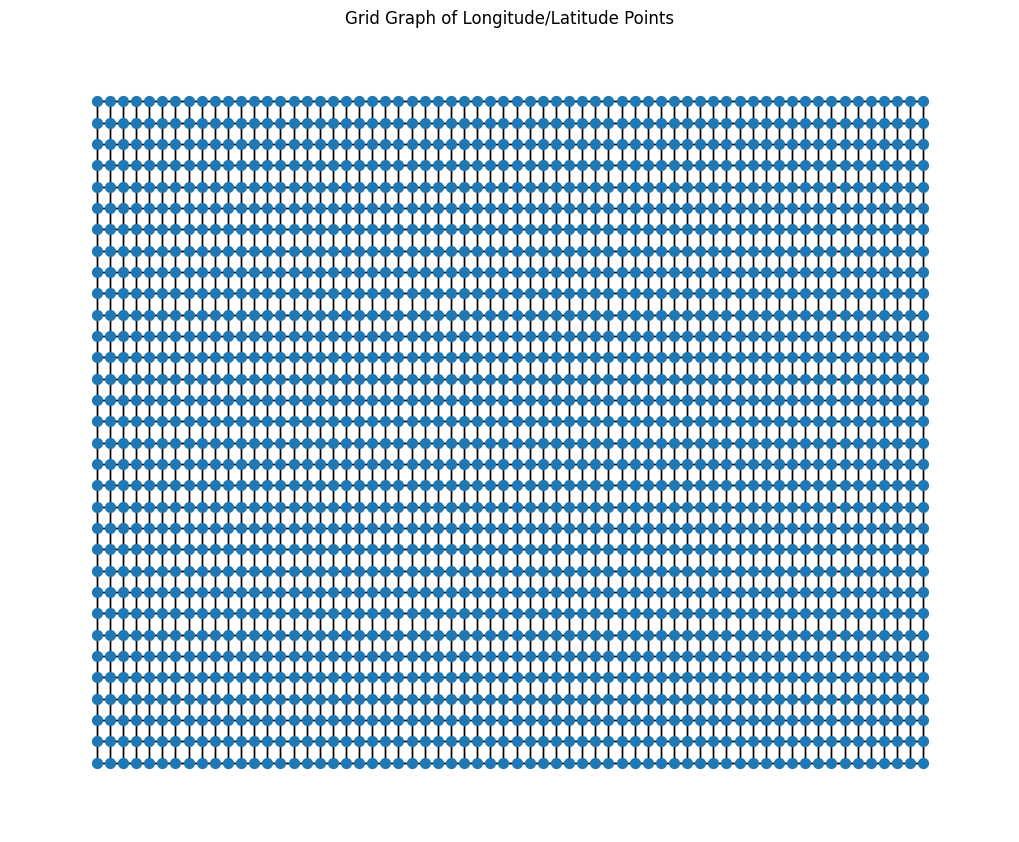

In [19]:
# Generate positions for the nodes (optional, for better visualization)
pos = {(lon, lat): (lon, lat) for lon in longitude for lat in latitude}

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=False, node_size=50)
plt.title("Grid Graph of Longitude/Latitude Points")
plt.show()